In [1]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import dblquad

In [130]:
def integrate(c1, c2, rp, rm, bp, bpm, theta):
    
    if theta > np.pi:
        theta -= np.pi
    
    intensity = lambda y, x: 1 - c1 * (1 - np.sqrt(1 - x*x - y*y)) - c2 * (1 - np.sqrt(1 - x*x - y*y))**2
    
    # first find (x, y) coords for centers
    xp = bp
    yp = 0.0
    xm = xp + bpm * np.cos(theta)
    ym = yp + bpm * np.sin(theta)
    
    # now find upper and lower boundaries for the circles 
    # assuming they're completely inside the star's boundary
    xpl = lambda x: yp - np.sqrt(rp * rp - (x - xp) * (x - xp))
    xpu = lambda x: yp + np.sqrt(rp * rp - (x - xp) * (x - xp))
    xml = lambda x: ym - np.sqrt(rm * rm - (x - xm) * (x - xm))
    xmu = lambda x: ym + np.sqrt(rm * rm - (x - xm) * (x - xm))
    
    # and the limits in x:
    xpa = xp - rp
    xpb = xp + rp
    xma = xm - rm
    xmb = xm + rm
    
    # non-overlapping case
    if rp + rm < bpm:
        integral = dblquad(intensity, xpa, xpb, xpl, xpu)[0] + dblquad(intensity, xma, xmb, xml, xmu)[0]
        
    elif (bpm + rm < rp):
        integral = dblquad(intensity, xpa, xpb, xpl, xpu)[0]
        
    else:
        # full integral over both circles 
        integral = dblquad(intensity, xpa, xpb, xpl, xpu)[0] + dblquad(intensity, xma, xmb, xml, xmu)[0]
        
        # find intersections:
        a = rp
        b = rm
        c = bpm
        if c >= b:
            tmp = c
            c = b
            b = tmp
        if b >= a:
            tmp = b
            b = a
            a = tmp
            
        delta = np.sqrt((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c)))
        pp = np.arctan2(delta, (rp - rm) * (rp + rm) + bpm * bpm) 
        iy1 = yp + rp * np.sin(theta + pp)    
        iy2 = yp + rp * np.sin(theta - pp)
        ix1 = xp + rp * np.cos(theta + pp)
        ix2 = xp + rp * np.cos(theta - pp)
        if ix1 > ix2:
            tmp = ix1
            ix1 = ix2
            ix2 = tmp
            
            tmp = iy1
            iy1 = iy2
            iy2 = tmp
                    
        if ((iy1 < yp) & (iy2 > yp)) | ((iy2 < yp) & (iy1 > yp)):
            # then we have to integrate lower planet boundary to upper planet boundary 
            # over the part of the overlap from ix2 to xpb
            integral -= dblquad(intensity, xpa, ix2, xpl, xpu)[0]
            if ((iy1 < ym) & (iy2 > ym)) | ((iy2 < ym) & (iy1 > ym)):
                # then we have to do the same for the moon from 
                # xma to ix1
                integral -= dblquad(intensity, ix1, xmb, xml, xmu)[0]
        
        if theta > np.pi / 2:
            # integrate from lower moon boundary to upper planet boundary 
            # from ix1 to ix2
            integral -= dblquad(intensity, ix1, ix2, xml, xpu)[0]
        else:
            # integrate from lower planet boundary to upper moon boundary from 
            # ix1 to ix2
            integral -= dblquad(intensity, ix1, ix2, xpl, xmu)[0]
                        
    return integral

In [133]:
t = np.linspace(0, 1, 1000)
bp = np.abs(np.linspace(-0.6, -0.2, 1000))
bm = np.abs(np.linspace(-0.95, 0.0, 1000))
bpm = np.abs(bp - bm)
theta = np.zeros_like(bp)

for i, (bpi, bpmi, bmi) in enumerate(zip(bp, bpm, bm)):
    a, b, c = bpi, bpmi, bmi
    if b > a : 
        tmp = b
        b = a
        a = tmp
    if c > b :
        tmp = c
        c = b
        b = tmp
    if b > a :
        tmp = b
        b = a
        a = tmp
    delta = np.sqrt((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c)))
    theta[i] = np.arctan2(delta, (bpi - bmi) * (bpi + bmi) + bpmi * bpmi)

lc = 1 - np.array([integrate(0.5, 0.5, 0.05, 0.02, bpi, bpmi, thetai) for bpi, bpmi, thetai in zip(bp, bpm, theta)])

(0.99122, 0.99126)

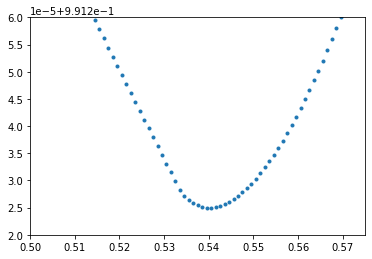

In [141]:
import matplotlib.pyplot as plt
plt.plot(t, lc, '.')
plt.xlim(0.5, 0.575)
plt.ylim(0.99122, 0.99126)

In [142]:
import ctypes
from array import array
photlib = ctypes.CDLL("./c_src/cwrapper.so")
fortran = ctypes.CDLL("./c_src/fwrapper.so")
def flux(c1, c2, rp, rm, bp, bpm, cth, sth):
    
    bp = (ctypes.c_double * len(bp)).from_buffer(bp)
    bpm = (ctypes.c_double * len(bpm)).from_buffer(bpm)
    cth = (ctypes.c_double * len(cth)).from_buffer(cth)
    sth = (ctypes.c_double * len(sth)).from_buffer(sth)
    lc = ((ctypes.c_double * 8) * len(bp)).from_buffer(np.zeros((8, len(bp))))
    rp = ctypes.c_double(rp)
    rm = ctypes.c_double(rm)
    c1 = ctypes.c_double(c1)
    c2 = ctypes.c_double(c2)
    j = ctypes.c_int(len(bp))
    photlib.LC.restype = None
    photlib.LC(c1, c2, rp, rm, bp, bpm, cth, sth, lc, j)
    return np.array(lc)

(0.99122, 0.99126)

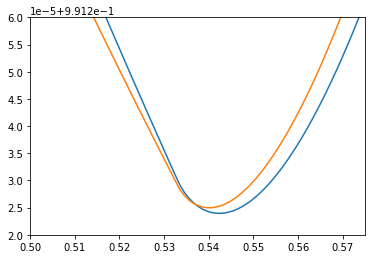

In [174]:
lc2 = flux(0.5, 0.5, 0.05, 0.02, bp, bpm, np.cos(theta), np.sin(theta))
plt.plot(t, lc2[:, 0]*2.367 + 1)
plt.plot(t, lc)
plt.xlim(0.5, 0.575)
plt.ylim(0.99122, 0.99126)

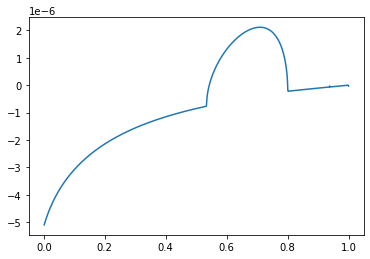

In [175]:
plt.plot(t[1:], np.diff(lc2[:, 0]))